# Notebook 
### Contribution Statement:

We, Frida(s206182), Cecilie(s214605), and Marie(s204052), collaborated and contributed equally to the project at hand.

In [4]:
# Reading packages
from bs4 import BeautifulSoup
import requests
import math
import pandas as pd
import pickle
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import os
import networkx as nx
import networkx.algorithms.community as nx_community
import re
import string
import networkx.algorithms.community as nx_comm
import netwulf
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
from collections import Counter

# Semantics analysis
%pip install textblob
import nltk
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import defaultdict
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from PIL import Image


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1129)>


## Table of contents

1. [Datachoice](#data-choice)
    * [What data did we choose?](#what-data)  
    * [Why is this data interesting?](#motivation) 
<br>
<br>

2. [Data collection and filtering](#data-processing)
    * [Collecting data with Harry Potter API](#API)
    * [Webscraping wikis](#webscraping)
    * [Initial filtering of the data](#initial-filtering)
        * [Filtering based on 5 requirements](#remove-inanimate)
        * [Cleaning houses and species](#cleaning_filters)
    * [Visualizations of the data](#visualizations)
        * [Distribution of species](#dist_species)
        * [Wordcloud of species](#wordcloud_species)
        * [Histogram of houses](#houses_hist)
<br>
<br>

3. [Making the network](#make-network)
    * [Initializing graph and edgelist](#init-graph)
    * [Visualizing graph](#visualizing_graph)
    * [Making random network](#make-random-network)
        * [Adding weights](#weights-random-network)
        * [Visualizing random graph](#visualizing_random_graph)
    * [Visualize degree and weight distribution](#visualize-degree)
<br>
<br>

4. [Network statistics](#statistics)
    * [Harry Potter network](#harry_statistics)
        * [Statistical measurements](#harry_mean_median_osv)
        * [Clustering coefficient](#harry_clustering_coef)
        * [Assorsativity](#harry_assorsativity)
        * [Shortest path](#harry_shortest_path)
        * [Closeness centrality](#harry_closeness_cent)
    * [Random network](#random_statistics)
        * [Statistical measurements](#random_mean_median_osv)
        * [Clustering coefficient](#random_clustering_coef)
        * [Assorsativity](#random_assorsativity)
        * [Shortest path](#random_shortest_path)
        * [Closeness centrality](#random_closeness_cent)
    * [Distribution of shortest paths](#dist_shortest_paths)
    * [Distribution of closeness centrality](#dist_closeness_cent)
    * [Investigating communities](#init_communities)
        * [House communities](#house_communities)
        * [Louvain communities](#louvain_communities)
        * [Distribution of communitiy sizes](#dist_communities_size)
<br>
<br>

5. [Text analysis](#semantic-analysis)
    * [Statistics](#semantic-analysis_statistics)
        * [Distribution of text lengths](#dist_text_length)
    * [Tokenize](#tokenize)
        * [Distribution of tokenized text lengths](#dist__tokenized_text_length)
        * [Comparing text and tokenized text](#text_compare)
    * [House wordclouds](#house-wordclouds)
        * [TD-IDF scores](#house_td_idf)
    * [Personal wordclouds](#personal-wordclouds)

# 1. Motivation <a id='data-choice'></a>

<a id='what-data'></a>
### What data did we choose? 



We will use the Harry Potter API to get all characters in the universe, which will be nodes in a network. To create the network, we will use web scraping to determine edges between the nodes through hyperlinks on each character's page on the Harry Potter Wiki. To populate the nodes with attributes we will use a Harry Potter database API. We will perform text processing on the content of the specific pages for individuals on the Harry Potter Wiki.

The different sections of our analysis can be found using the Navigation Menu in the top right corner. And all the behind the scenes stuff, including code and further explanations can be found in this notebook.

<a id='motivation'></a>
### Why is this data interesting?

Our main concept is to analyze the network of Harry Potter characters. The assumption is that the Harry Potter universe functions as a (real) network, and that Wiki pages are a good documentation of the universe (because the fictional world is so well-documented with info from books, movies, etc.). The purpose of the task is to investigate whether expectations about the Harry Potter universe align with what a network based on Wiki information would reveal. We will explore the Harry Potter universe by mapping connections on their wiki pages. This means that each character is a node, and edges come from references to other people in the text (directed, weighted edges by number of references). 

<a id='data-processing'></a>
# 2. Data collection and filtering

<a id='unique-id'></a>
## Collecting data with Harry Potter API

In [ ]:
# API link
BASE_URL = "https://api.potterdb.com/"
VERSION = "v1/"
RESOURCE = "characters"

my_url = BASE_URL + VERSION + RESOURCE
print(my_url)
all_data = {}
counter = 0
for i in range(50):

    url = my_url + f"?page[number={i+1}]&page[size=100]"
    r = requests.get(url)
    data = r.json()["data"]

    for i in data:
        all_data[counter] = {}
        name = (i['attributes']['name'])
        all_data[counter]['Name'] = i['attributes']['name']
        all_data[counter]['Blood status'] = i['attributes']['blood_status']
        all_data[counter]['House'] = i['attributes']['house']
        all_data[counter]['Species'] = i['attributes']['species']
        all_data[counter]['Death time'] = i['attributes']['died']
        all_data[counter]['Alias'] = i['attributes']['alias_names']
        all_data[counter]['Wiki'] = i['attributes']['wiki']
        all_data[counter]['Gender'] = i['attributes']['gender']
        counter +=1
    
df_data = pd.DataFrame.from_dict(all_data, orient='index')

<a id='webscraping'></a>
## Webscrape text data and node links from wiki

In [114]:
# Function to webscrape Harry Potter wiki for text and links
def webscrapeWiki(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    content_div = soup.find('div', {'id': 'mw-content-text'})
    text = ""
    exclude_sections = ["Appearances"]
    exclude_links = ["Appearances"]

    for p in content_div.find_all('p'):
        section_heading = p.find_previous_sibling('h2')
        if section_heading and section_heading.find('span', {'class': 'mw-headline'}).text in exclude_sections:
            break
        elif p.find_parents('table'):
            continue
        text += p.get_text() + " "

    links = []
    for ul in content_div.find_all("ul"):
        section_heading = ul.find_previous_sibling('h2')
        if section_heading and section_heading.find('span', {'class': 'mw-headline'}).text in exclude_sections:
            break
        elif ul.find_parents('table'):
            continue
        for li in ul.find_all("li"):
            for a in li.find_all("a"):
                if a.find_parents('table'):
                    continue
                split = a['href'].split("/")
                if len(split)>1:
                    if split[1]=="wiki" and section_heading is not None and section_heading.find('span', {'class': 'mw-headline'}).text not in exclude_links:
                        links.append(split[2])
    
    infobox = soup.find('aside', {'class': 'portable-infobox'})
    if infobox:
        for a in infobox.find_all('a'):
            href = a.get('href')
            if href:
                split = href.split("/")
                if len(split)>1:
                    if split[1]=="wiki":
                        links.append(split[2])

    return text, links

df_data["Wiki text"], df_data["Character links"] = zip(*df_data["Wiki"].apply(webscrapeWiki))

In [209]:
df_data.head(2)

,name,Blood status,House,Species,Death time,Alias,Wiki,Gender,Wiki text,Character links,Wiki name,Sum character links
0,1992 Gryffindor vs Slytherin Quidditch match s...,None,None,None,None,None,https://harrypotter.fandom.com/wiki/1992_Gryff...,None,The title of this article is conjectural. Alt...,"[Canon, Filius_Flitwick, Irma_Pince, Severus_S...",1992_Gryffindor_vs_Slytherin_Quidditch_match_s...,"{'Filius_Flitwick': 2, 'Irma_Pince': 3, 'Sever..."
1,1996 Gryffindor Quidditch Keeper trials specta...,None,None,None,None,None,https://harrypotter.fandom.com/wiki/1996_Gryff...,None,"In September 1996, a number of unidentified sp...","[Harry_Potter_and_the_Half-Blood_Prince, Septe...",1996_Gryffindor_Quidditch_Keeper_trials_specta...,"{'Harry_Potter': 1, 'Ronald_Weasley': 1, 'Corm..."


In [120]:
def wikiName(wikiURL):
    return wikiURL.split("/")[-1]

def checkLinks(linkCounter, wikiNames):
    cleanLinks = linkCounter.copy()
    for link in linkCounter.keys():
        if link not in list(wikiNames):
            del cleanLinks[link]
    return cleanLinks

df_data["Wiki name"] = df_data["Wiki"].apply(wikiName)
df_data["Sum character links"] = df_data["Character links"].apply(Counter)
df_data["Sum character links"] = df_data["Sum character links"].apply(checkLinks,wikiNames=df_data["Wiki name"])

#Save dataframe
df_data.to_pickle("df_data_updated2")

<a id='initial-filtering'></a>
## Initial filtering of data

The data is saved in a pickle in order to improve the effectiveness of the code.

In [49]:
# Load dataframe:
df_data_loaded = pd.read_pickle("df_data_updated2")

### Filtering based on 5 requirements <a id='remove-inanimate'></a>

We apply five filters to the data:
1. If blood status, house, species, death time and alias were all “None”.
2. If name started with “unidentified”.
3. If name was in a list of actors webscraped from imdb.
4. If the species was “Humans” indicating that the entry was a group.
5. If character has degree 0 in the network.

In [50]:
# Getting filtered data
# Removing names holding 'Unidentified'
def checkUnidentified(wikiName):
    check = "Unidentified"
    if len(wikiName)>len(check):
        if wikiName[:len(check)]==check:
            return True
    return False

# Checking if links are persons
def checkLinks(linkCounter, wikiNames):
    cleanLinks = linkCounter.copy()
    for link in linkCounter.keys():
        if link not in list(wikiNames):
            del cleanLinks[link]
    return cleanLinks


def removeDegreeZeros(df):
    hasDegreeDict = {}
    # Check if each character has out-degree:
    for i in df.index:
        hasDegreeDict[df["Wiki name"][i]] = False
        if len(df["Sum character links"][i]):
            hasDegreeDict[df["Wiki name"][i]] = True
    
    # Look at all character in-degree references:
    for i in df.index:
        for n in df["Sum character links"][i]:
            hasDegreeDict[n] = True
    
    remove = [name for (name, degrStatus) in hasDegreeDict.items() if not degrStatus]
    df_degree = df.drop(df[df["Wiki name"].isin(remove)].index)
    return df_degree

# Function that scrapes actor names from each HP movies wikipediapage and appends them to a list
def scrape_actors(url, actor_names):
    response = requests.get(url)
    if response.status_code == 200:
        html_content = response.content
        soup = BeautifulSoup(html_content, 'html.parser')
        cast_element = soup.find('table', class_='cast_list')
        if cast_element:
            for row in cast_element.find_all('tr'):
                actor_element = row.find('td', class_='primary_photo')
                if actor_element:
                    actor_name = actor_element.find('img').get('alt')
                    if actor_name not in actor_names:
                        actor_names.append(actor_name)
    return actor_names

actor_names = []

# The Philosopher's Stone
url = 'https://www.imdb.com/title/tt0241527/fullcredits#cast'
actor_names = scrape_actors(url, actor_names)
# The Chamber of Secrets
url = 'https://www.imdb.com/title/tt0295297/fullcredits#cast'
actor_names = scrape_actors(url, actor_names)
# The Prisoner of Azkaban
url = 'https://www.imdb.com/title/tt0304141/fullcredits#cast'
actor_names = scrape_actors(url, actor_names)
# The Goblet of Fire
url = 'https://www.imdb.com/title/tt0330373/fullcredits#cast'
actor_names = scrape_actors(url, actor_names)
# The Order of the Phoenix
url = 'https://www.imdb.com/title/tt0373889/fullcredits#cast'
actor_names = scrape_actors(url, actor_names)
# Half-Blood Prince 
url = 'https://www.imdb.com/title/tt0417741/fullcredits#cast'
actor_names = scrape_actors(url, actor_names)
# The Deathly Hallows – Part 1
url = 'https://www.imdb.com/title/tt0926084/fullcredits#cast'
actor_names = scrape_actors(url, actor_names)
# The Deathly Hallows – Part 2
url = 'https://www.imdb.com/title/tt1201607/fullcredits#cast'
actor_names = scrape_actors(url, actor_names)

len_data = len(df_data_loaded)

# Filter data after having some information of Blood status, house, species, death time or alias
filtered_data = df_data_loaded[~((df_data_loaded["Blood status"].isnull())&(df_data_loaded["House"].isnull())&(df_data_loaded["Species"].isnull())&(df_data_loaded["Death time"].isnull())&(df_data_loaded["Alias"].isnull()))]
filt_data1 = len(filtered_data)

# Filter unidentified people away
filtered_data = filtered_data[~filtered_data["Wiki name"].apply(checkUnidentified)]
filt_data2 = len(filtered_data)


# Cleaning 'name' column for actornames
mask = ~filtered_data['Name'].isin(actor_names)
filtered_data = filtered_data[mask]
filt_data3 = len(filtered_data)


# Filter based on species (removing groups)
filtered_data = filtered_data[~(filtered_data['Species']=='Humans')]
filt_data4 = len(filtered_data)

# Remove links to non-characters:
filtered_data["Sum character links"] = filtered_data["Sum character links"].apply(checkLinks,wikiNames=filtered_data["Wiki name"])
# Remove characters with no links out or in:
filtered_data = removeDegreeZeros(filtered_data)
filt_data5 = len(filtered_data)

print('First filter removes:', len_data-filt_data1, 'characters')
print('Second filter removes:', filt_data1-filt_data2, 'characters')
print('Third filter removes:', filt_data2-filt_data3, 'characters')
print('Fourth filter removes:', filt_data3-filt_data4, 'characters')
print('Fifth filter removes:', filt_data4-filt_data5, 'characters')

First filter removes: 91 characters
Second filter removes: 431 characters
Third filter removes: 4 characters
Fourth filter removes: 56 characters
Fifth filter removes: 1731 characters


### Cleaning houses and species <a id='cleaning_filters'></a>

Next we cleaned the house names. Some house names had unnecessary information attached to the house name, which we removed. Furthermore, if they had long house names it typically was an explanation, which we changed to 'Unknown'. Lastly, None was changed to 'Unknown' to have one collective category.

Also the column describing the species of the characters are cleaned. Thereby gathering all characters who has no specific species or more than 1 species assigned.

In [52]:
def cleanHouses(House):
    if House != None:
        strings = House.split(' ')
        if len(strings) == 1:
            return strings[0]
        if len(strings) != 1:
            if len(strings) > 2:
                return 'Unknown'
            if strings[-1][-1] == ')':
                return strings[0]
    if House == None:
        return 'Unknown'

def cleanSpecies(species):
    if not species:
        return 'Unknown'
    else:
        return species

# Applying cleaning functions
filtered_data['House'] = filtered_data['House'].apply(cleanHouses)
filtered_data['Species'] = filtered_data['Species'].apply(cleanSpecies)

In [53]:
filtered_data.head(5)

,Name,Blood status,House,Species,Death time,Alias,Wiki,Gender,Wiki text,Character links,Wiki name,Sum character links
9,Aberforth Dumbledore,Half-blood,Unknown,Human,None,[Ab],https://harrypotter.fandom.com/wiki/Aberforth_...,Male,\n\n\n\n\n\n\n\nAberforth Dumbledore\n\n\nBiog...,"[Charm, Aberforth_Dumbledore%27s_goat_charm, P...",Aberforth_Dumbledore,"{'Albus_Dumbledore': 2, 'Gellert_Grindelwald':..."
10,Abernathy,None,Unknown,Human,None,None,https://harrypotter.fandom.com/wiki/Abernathy,Male,\n\n\n\n\n\n\n\nAbernathy\n\n\nBiographical in...,"[Apparition, Lestrange_Mausoleum, Abernathy%27...",Abernathy,"{'Percival_Graves': 1, 'Peter_Pettigrew': 1, '..."
13,Abigail R. Cankus,None,Unknown,Human,None,None,https://harrypotter.fandom.com/wiki/Abigail_R....,Female,\n\nAbigail R. Cankus\n\n\nBiographical inform...,"[United_States_of_America, Human, Template:Ind...",Abigail_R._Cankus,{}
15,Able Spudmore,None,Unknown,Human,None,None,https://harrypotter.fandom.com/wiki/Able_Spudmore,Male,\n\nAble Spudmore\n\n\nBiographical informatio...,"[1923, Human, Randolph_Spudmore, Spudmore_fami...",Able_Spudmore,{'Randolph_Spudmore': 1}
16,Abraham,None,Unknown,Human,None,None,https://harrypotter.fandom.com/wiki/Abraham,Male,"""Point me!""\n \n\n\n\n\n\n\n\nAbraham\n\n\nPhy...",[Harry_Potter_and_the_Philosopher%27s_Stone_(f...,Abraham,"{'Albus_Dumbledore': 1, 'Isaac': 1}"


## Visualizations of the data <a id='visualizations'></a>

### Distribution of species <a id='dist_species'></a>

First we investigate the species and visualized the different types. This is to understand the characters better.

In [54]:
# Top 10 species
top_species = pd.DataFrame(filtered_data['Species'].value_counts().head(5))
top_species

,Species
Human,1518
"Human (formerly), Ghost",13
Goblin,10
Giant,9
House-elf,9


### Wordcloud of species <a id='wordcloud_species'></a>

Another way to investigate the distribution of species among charaters is by making a wordcloud of the species column in the dataset. Meaning that species that occur more often will be larger in the wordcloud and vice versa. Below both a function for making the wordcloud as well as the actual wordcloud for the speciec column is shown.

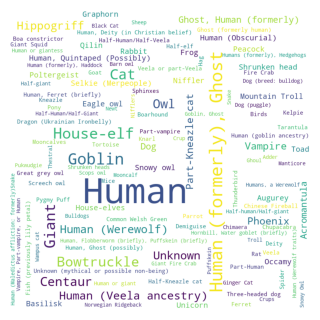

In [ ]:
# Define a function to generate wordcloud
def generate_freq_wordcloud(data):
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10)
    wordcloud.generate_from_frequencies(frequencies = data)
    plt.figure(figsize = (3,3), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show() 

species_freq = dict(Counter(filtered_data['Species']))
generate_freq_wordcloud(species_freq)


### Histogram of houses <a id='houses_hist'></a>

Next we look at the distribution of characters into houses as this division plays an essential role in the lore of the universe.

In [55]:
# Getting data ready for plotting in a histogram
houses = filtered_data['House']
houses_types = []
for i in houses:
    if i not in houses_types:
        houses_types.append(i)

dict = {}
for i in range(len(houses_types)):
    dict[i] = houses_types[i]

keys = list(dict.keys())
values = list(dict.values())

houses_int = []
for i in houses:
    for j in range(len(values)):
        if i == values[j]:
            houses_int.append(keys[j])

dict_len = []
for i in range(len(houses_types)):
    dict_len.append(len(filtered_data[filtered_data['House']==houses_types[i]]))

len_houses = pd.DataFrame()
len_houses['House'] = dict.values()
len_houses['Count'] = dict_len

In [56]:
import plotly.express as px
# Plotting the distribution of house sizes
fig = px.bar(len_houses, x='House', y='Count', title="Count of members in each house", width=800, height=400)
fig.update_traces(width=0.8, marker_color=[('#ffc500'), ('#1a472a'), ('#0a5ea8'), ('#7f0909'), ('#8A8C8A'), ('#8A8C8A'),('#8A8C8A')], opacity=0.75)
fig.update_xaxes(griddash = 'solid')
fig.update_layout(title_x=0.5)
fig.show()

# Save figure as png
#fig.write_image("houses_count.png")

From the plot it is clear, that the characters assigned with a unknown house is much greater than the rest of the house sizes.

# 3. Making the network <a id='make-network'></a>

### Initializing graph and edgelist  <a id='init-graph'></a>

First, we initialized the graph using all the characters wiki names as nodes and their house as the group attribute of the node.

In [57]:
# making edgelist
wiki_names = list(filtered_data['Wiki name'])
character_links = filtered_data['Sum character links']
houses = list(filtered_data['House'])

# Initializing graph
G = nx.DiGraph()
# Adding node with group according to house attribute
for i in range(len(wiki_names)):
        G.add_node(wiki_names[i], group = houses[i])
print(G)

DiGraph with 1751 nodes and 0 edges


Next we used the references found on the wiki pages to make weighted edges between the nodes.

In [58]:
# Making weighted edgelist
edges = []
for j in filtered_data.index:
    name = filtered_data['Wiki name'][j]
    links = filtered_data['Sum character links'][j]
    for key, val in links.items():
        edges.append(((name, key, val)))

# Adding edgelist to graph
G.add_weighted_edges_from(edges)
print(G)

DiGraph with 1751 nodes and 7852 edges


Earlier, we filtered out characters with not edges, but as an extra check we will attempt to remove 0 degree nodes. 

In [23]:
# Remove nodes with no edges
remove = [node for node,degree in G.degree() if degree == 0]
G.remove_nodes_from(remove)
print(f"{len(remove)} nodes with degree 0 were removed.") # Should be 0 as they are already removed

0 nodes with degree 0 were removed.


### Visualizing graph  <a id='visualizing_graph'></a>

In [12]:
# Interactive visualization of graph (with group attribute according to 'house')
netwulf.interactive.visualize(G)

(None, None)

## Making random network  <a id='make-random-network'></a>

To compare out Harry Potter graph, we create a random graph. It has the same number of nodes and edges. It will still be directed, but the in- and out-degrees of the nodes will not be upheld. The edges will have the same distribution of weights, but they will be assigned the edges randomly.

In [59]:
# Initliazing random graph with same number of nodes and edges as Harry Potter network
rand_G = nx.gnm_random_graph(len(G.nodes(data=True)), len(G.edges()), seed=42, directed=True)
print(rand_G)

DiGraph with 1751 nodes and 7852 edges


### Adding weights  <a id='weights-random-network'></a>

In [60]:
#collect lists:
weights = []
for (name1, name2, weight) in G.edges.data():
    weights.append(weight['weight'])
# randomize list:
random.shuffle(weights)

rand_G.edges.data("weight",default=1)

for tupl in rand_G.edges.data():
    tupl[2]['weight'] = weights.pop()


#### Visualizing random graph <a id='visualizing_random_graph'></a>

In [43]:
# Visualizing random graph
netwulf.interactive.visualize(rand_G)

(None, None)

## Visualize degree and weight distribution
 <a id='visualize-degree'></a>

To start understanding the Harry Potter network we will investigate the degrees. Since we are working with a directed graph we will be working with both the in- and out-degrees. First we will find the top characters based on in- and out-degree. 

In [61]:
# Finding top 10 nodes (characters) with highest in-degree and out-degree
in_degrees = {}
for i in G.in_degree:
    new_name=i[0].replace('_', ' ')
    in_degrees[new_name] = i[1]

out_degrees = {}
for i in G.out_degree:
    new_name=i[0].replace('_', ' ')
    out_degrees[new_name] = i[1]

max_in_deg = sorted(in_degrees, key=in_degrees.get, reverse=True)[:10]
max_out_deg = sorted(out_degrees, key=out_degrees.get, reverse=True)[:10]

in_df = pd.DataFrame(sorted(in_degrees.values(), reverse=True)[:10],max_in_deg,columns=['In-degree'])
out_df = a = pd.DataFrame(sorted(out_degrees.values(), reverse=True)[:10],max_out_deg,columns=['Out-degree'])

In [62]:
in_df

,In-degree
Harry Potter,210
Tom Riddle,187
Albus Dumbledore,111
Ronald Weasley,94
Hermione Granger,90
Sirius Black,67
Ginevra Weasley,65
Severus Snape,65
Arthur Weasley,62
Draco Malfoy,62


In [26]:
out_df

,Out-degree
Harry Potter,92
Albus Dumbledore,73
Jacob's sibling,62
Ronald Weasley,60
Hermione Granger,59
Arthur Weasley,49
Bellatrix Lestrange,48
Ginevra Weasley,48
Cedrella Black,45
Tom Riddle,43


Next, we will plot the degree distributions. The distributions are heavy tailed, so we have used a logarithmic scale.

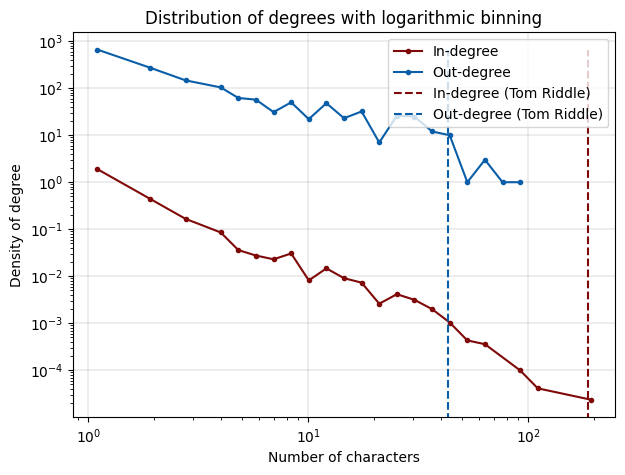

In [33]:
# Using matplotlib to plot the distribution of in-degrees and out-degrees
in_degrees = [degree for character, degree in G.in_degree()]
out_degrees = [degree for character, degree in G.out_degree()]

bins = np.logspace(0, np.log10(max(in_degrees)),30)
hist, edges = np.histogram(list(in_degrees), bins = bins, density = True)
x = (edges[1:] + edges[:-1])/2

xx, yy = zip(*[(i, j) for (i,j) in zip(x, hist) if j>0])

fig, ax = plt.subplots(dpi=100,figsize=(7,5))
ax.plot(xx, yy, marker='.', label='In-degree', color=('#7f0909'))
hist, edges = np.histogram(list(out_degrees), bins = bins, density = False)
x = (edges[1:] + edges[:-1])/2

xx, yy = zip(*[(i, j) for (i,j) in zip(x, hist) if j>0])
ax.plot(xx, yy, marker='.', label='Out-degree', color=('#0a5ea8'))

ax.set_xlabel('Number of characters')
ax.set_ylabel('Density of degree')
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_title("Distribution of degrees with logarithmic binning")
ax.vlines(187,  0, max(yy), ls="--", colors=('#7f0909'), label='In-degree (Tom Riddle)')
ax.vlines(43,  0, max(yy), ls="--", colors=('#0a5ea8'), label='Out-degree (Tom Riddle)')
ax.legend(loc='upper right')
ax.grid(color='grey', linestyle='-', linewidth=0.2)
plt.savefig('degree_distribution_network.png', dpi=300)
plt.show()

The plot above does not show the relation between in- and out-degree per character. To investigate whether characters with a high in-degree also has a high out-degree we plot the relation between the two measures below:

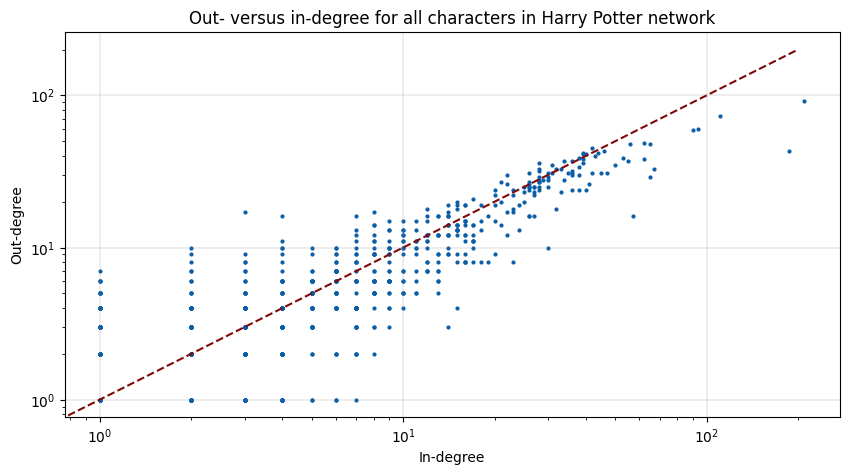

In [35]:
# Plotting in-degree vs out-degree (finding an relationship)
in_degrees = [degree for character, degree in G.in_degree()]
out_degrees = [degree for character, degree in G.out_degree()]

fig, ax = plt.subplots(figsize=(10,5) ,dpi=100)
ax.scatter(in_degrees, out_degrees, c=('#0a5ea8'), s=4)
ax.set_yscale("log")
ax.set_xscale("log")
ax.plot([0, 10, 50, 100, 150, 175, 200], [0, 10, 50, 100, 150, 175, 200], "--", color=('#7f0909'))
ax.set_xlabel('In-degree')
ax.set_ylabel('Out-degree')
ax.set_title('Out- versus in-degree for all characters in Harry Potter network')
ax.grid(color='grey', linestyle='-', linewidth=0.2)
plt.savefig('in_out_scatter.png', dpi=300)

So far, we have not considered the weights of the edges. They work as attributes of the edge and can be extracted from each edge. Below we visualize the distribution of the weights. This distribution is also heavy tailed, wherefore we plot it in logarithmic scale.

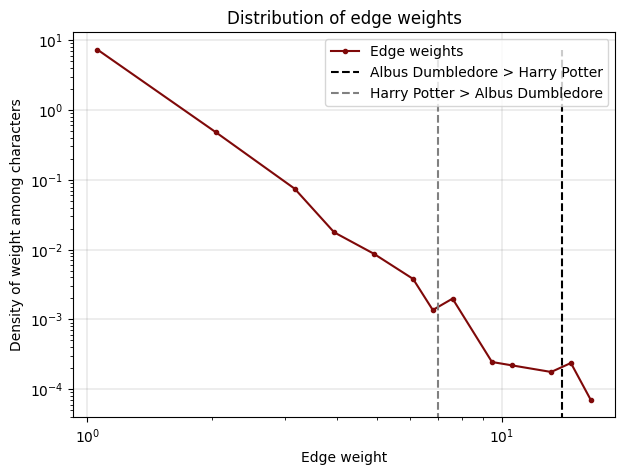

In [32]:
# Looking at the distribution of edge weights
all_weights = []
for i in list(G.edges(data=True)):
    w = list(i[2].values())
    all_weights.append(w[0])

bins = np.logspace(0, np.log10(max(all_weights)),30)
hist, edges = np.histogram(list(all_weights), bins = bins, density = True)
x = (edges[1:] + edges[:-1])/2

xx, yy = zip(*[(i, j) for (i,j) in zip(x, hist) if j>0])

fig, ax = plt.subplots(dpi=100,figsize=(7,5))
ax.plot(xx, yy, marker='.', label='Edge weights', color=('#7f0909'))

ax.set_xlabel('Edge weight')
ax.set_ylabel('Density of weight among characters')
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_title("Distribution of edge weights")
ax.vlines(14,  0, max(yy), ls="--", colors='black', label='Albus Dumbledore > Harry Potter')
ax.vlines(7,  0, max(yy), ls="--", colors='grey', label='Harry Potter > Albus Dumbledore')
ax.legend(loc='upper right')
ax.grid(color='grey', linestyle='-', linewidth=0.2)
plt.savefig('edge_weight_distribution_network.png', dpi=300)
plt.show()

Using a logarithmic scale, we see an almost linear relation between the density and edge weight meaning the majority of the edges have a very low weight and a few edges have very high weights. In the plot, we have show the edges between Harry Potter and Albus Dumbledore. We see that the Dumbledore wiki page references Harry more times than the Harry Potter wiki references Dumbledore.

# 4. Network statistics <a id='statistics'></a>

In [36]:
import scipy.stats as stats
# find mean, median, mode, min, max of both in and out degrees of Harry Potter network and random network
def findStats(G):
    min_in = np.min([d for n, d in G.in_degree()])
    min_out = np.min([d for n, d in G.out_degree()])
    print('Minimum of in-degree: ', min_in, ', and out-degree:', min_out)
    
    max_in = np.max([d for n, d in G.in_degree()])
    max_out = np.max([d for n, d in G.out_degree()])
    print('Maximum of in-degree: ', max_in, ', and out-degree:', max_out)
    
    mean_in = np.mean([d for n, d in G.in_degree()])
    mean_out = np.mean([d for n, d in G.out_degree()])
    print('Mean of in-degree: ', mean_in, ', and out-degree:', mean_out)
    
    median_in = np.median([d for n, d in G.in_degree()])
    median_out = np.median([d for n, d in G.out_degree()])
    print('Median of in-degree:', median_in,', and out-degree:', median_out)
    
    mode_in = stats.mode([d for n, d in G.in_degree()], keepdims=True)
    mode_out = stats.mode([d for n, d in G.out_degree()], keepdims=True)
    print('Mode of in-degree:', mode_in.mode,', and out-degree:', mode_out.mode)

## Harry Potter network <a id='harry_statistics'></a>

### Statistical measurements <a id='harry_mean_median_osv'></a>

In [37]:
# Harry Potter network
findStats(G)

Minimum of in-degree:  0 , and out-degree: 0
Maximum of in-degree:  210 , and out-degree: 92
Mean of in-degree:  4.484294688749286 , and out-degree: 4.484294688749286
Median of in-degree: 1.0 , and out-degree: 2.0
Mode of in-degree: [0] , and out-degree: [1]


### Average clustering coefficient <a id='harry_clustering_coef'></a>

In [66]:
# Average clustering coefficient of Harry Potter network
av_clust = nx.average_clustering(G)
print('Average clustering coefficient of Harry Potter network:', av_clust)

Average clustering coefficient of Harry Potter network: 0.30371066676110486


### Largest clustering coefficient <a id='harry_largest_clustering_coef'></a>

In [39]:
from tabulate import tabulate
# Finding the top 10 characters with the highest clustering coefficient
count0 = 0
count1 = 0
all_coef = list(nx.clustering(G).items())
for i in list(nx.clustering(G).items()):
    if i[-1] == 0.0:
        count0 += 1
        all_coef.remove(i)
    if i[-1] == 1.0:
        count1 += 1
        all_coef.remove(i)

print('Number of characters with clustering coefficient equal to 0:', count0)
print('Number of characters with clustering coefficient equal to 1:', count1)

all_coef.sort(key = lambda x: x[1], reverse=True)
print(tabulate(all_coef[0:5], headers=['Character', 'Clustering coefficient']))

Number of characters with clustering coefficient equal to 0: 817
Number of characters with clustering coefficient equal to 1: 200
Character           Clustering coefficient
----------------  ------------------------
Lucy_Weasley                      0.9848
Sirius_Black_I                    0.981481
Stamford_Jorkins                  0.98
Audrey_Weasley                    0.9792
Mary_Riddle                       0.96875


### Assorsativity <a id='harry_assorsativity'></a>

In [97]:
in_in = nx.degree_assortativity_coefficient(G, x='in', y='in')
in_out = nx.degree_assortativity_coefficient(G, x='in', y='out')
out_in = nx.degree_assortativity_coefficient(G, x='out', y='in')
out_out = nx.degree_assortativity_coefficient(G, x='out', y='out')

# Putting all the assortativity coefficients in a table
rows = [['In-degree', in_in, in_out], ['Out-degree', out_in, out_out]]
print(tabulate(rows, headers=['', 'In-degree', 'Out-degree']))

              In-degree    Out-degree
----------  -----------  ------------
In-degree      0.043646      0.12583
Out-degree     0.070133      0.199737


### Shortest path <a id='harry_shortest_path'></a>

In [88]:
# Finding largest connected component
ll_hp = max(nx.strongly_connected_components(G), key=len)
print('Largest strongly connected subgraph in Harry Potter network is:', len(ll_hp))
# Average shortest path in largest connected component
avg_short_path = nx.average_shortest_path_length(G.subgraph(ll_hp))
print('Average shortest path in the largest connected component in Harry Potter network is:', avg_short_path)

Largest strongly connected subgraph in Harry Potter network is: 562
Average shortest path in the largest connected component in Harry Potter network is: 3.659466763088283


In [89]:
# Distribution of the shortest path
lengths = []
for i in ll_hp:
    lengths.append(nx.shortest_path_length(G.subgraph(ll_hp), source=i))
lengths = [x for y in lengths for x in y.values()]

The distribution of shortest path is plotted by the distribution for shortest paths section.

### Closeness centrality <a id='harry_closeness_cent'></a>

In [106]:
# Average closeness centrality of random network
av_close_hp = []
for i in nx.closeness_centrality(G).values():
    av_close_hp.append(i)
print('Average closeness centrality of Harry Potter network: ', np.mean(av_close_hp))

Average closeness centrality of Harry Potter network:  0.06403777053280169


The distribution of closeness centrality among nodes in the Harry Potter network is plotted in the section distribution for closeness centrality.

## Random network <a id='random_statistics'></a>

### Statistical measurements <a id='random_mean_median_osv'></a>

In [43]:
# Statistics of random network
findStats(rand_G)

Minimum of in-degree:  0 , and out-degree: 0
Maximum of in-degree:  13 , and out-degree: 13
Mean of in-degree:  4.484294688749286 , and out-degree: 4.484294688749286
Median of in-degree: 4.0 , and out-degree: 4.0
Mode of in-degree: [4] , and out-degree: [4]


### Average clustering coefficient <a id='random_clustering_coef'></a>

In [53]:
# Computing clustering coefficient using networkx function
clust_rand = nx.average_clustering(rand_G)
print('Clustering coefficient of random network: ', clust_rand)

Clustering coefficient of random network:  0.002668296101460343


### Assorsativity <a id='random_assorsativity'></a>

In [98]:
in_in = nx.degree_assortativity_coefficient(rand_G, x='in', y='in')
in_out = nx.degree_assortativity_coefficient(rand_G, x='in', y='out')
out_in = nx.degree_assortativity_coefficient(rand_G, x='out', y='in')
out_out = nx.degree_assortativity_coefficient(rand_G, x='out', y='out')

# Putting all the assortativity coefficients in a table
rows = [['In-degree', in_in, in_out], ['Out-degree', out_in, out_out]]
print(tabulate(rows, headers=['', 'In-degree', 'Out-degree']))

              In-degree    Out-degree
----------  -----------  ------------
In-degree     0.0198941    0.00270551
Out-degree    0.0212653    0.00019944


### Shortest path <a id='random_shortest_path'></a>

In [90]:
# Finding largest connected component
ll_rand = max(nx.strongly_connected_components(rand_G), key=len)
print('Largest strongly connected subgraph in random network is:', len(ll_rand))
# Average shortest path in largest connected component
avg_short_path = nx.average_shortest_path_length(rand_G.subgraph(ll_rand))
print('Average shortest path in the largest connected component in random network is:', avg_short_path)

Largest strongly connected subgraph in random network is: 1717
Average shortest path in the largest connected component in random network is: 5.149643697401414


In [91]:
# Distribution of the shortest path for random network
lengths_rand = []
for i in ll_rand:
    lengths_rand.append(nx.shortest_path_length(rand_G.subgraph(ll_rand), source=i))
lengths_rand = [x for y in lengths_rand for x in y.values()]

### Closeness centrality <a id='random_closeness_cent'></a>

In [108]:
# Average closeness centrality of random network
av_close_rand = []
for i in nx.closeness_centrality(rand_G).values():
    av_close_rand.append(i)
print('Average closeness centrality of random network: ', np.mean(av_close_rand))

Average closeness centrality of random network:  0.19165483740264888


### Distribution of shortest paths <a id='dist_shortest_paths'></a>

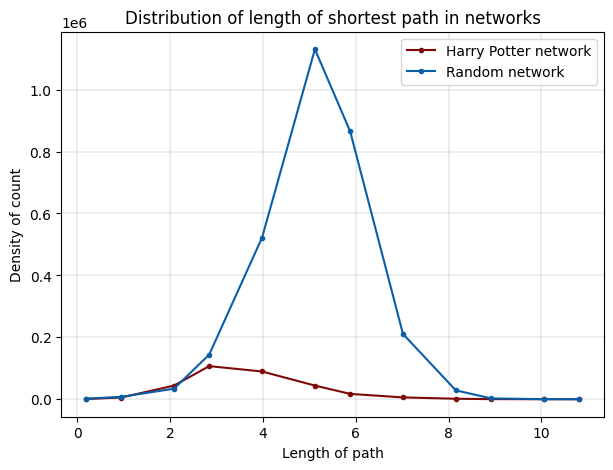

In [116]:
bins = np.linspace(min(lengths), max(lengths),30)
hist, edges = np.histogram(list(lengths), bins = bins, density = False)
x = (edges[1:] + edges[:-1])/2

xx, yy = zip(*[(i, j) for (i,j) in zip(x, hist) if j>0])

fig, ax = plt.subplots(dpi=100,figsize=(7,5))
ax.plot(xx, yy, marker='.', label='Harry Potter network', color=('#7f0909'))

hist, edges = np.histogram(list(lengths_rand), bins = bins, density = False)
x = (edges[1:] + edges[:-1])/2
xx, yy = zip(*[(i, j) for (i,j) in zip(x, hist) if j>0])
ax.plot(xx, yy, marker='.', label='Random network', color=('#0a5ea8'))

ax.set_xlabel('Length of path')
ax.set_ylabel('Density of count')
ax.set_title("Distribution of length of shortest path in networks")
ax.legend(loc='upper right')
ax.grid(color='grey', linestyle='-', linewidth=0.2)
#plt.savefig('shortest_path_distribution.png', dpi=300)
plt.show()

### Distribution of closeness centrality <a id='dist_closeness_cent'></a>

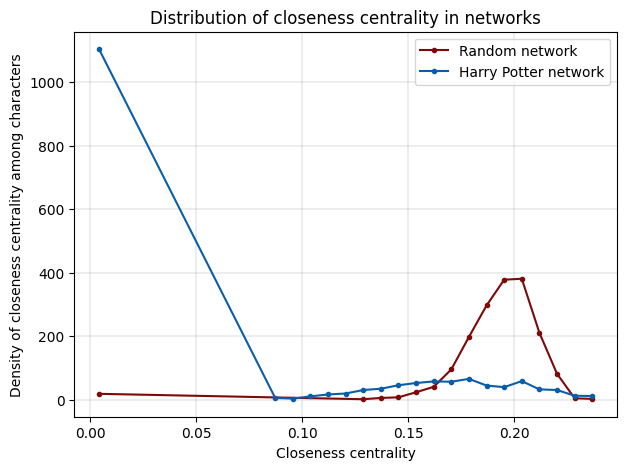

In [110]:
# Plotting distribution of closeness centrality
bins = np.linspace(min(av_close_rand), max(av_close_rand),30)
hist, edges = np.histogram(list(av_close_rand), bins = bins, density = False)
x = (edges[1:] + edges[:-1])/2

xx, yy = zip(*[(i, j) for (i,j) in zip(x, hist) if j>0])

fig, ax = plt.subplots(dpi=100,figsize=(7,5))
ax.plot(xx, yy, marker='.', label='Random network', color=('#7f0909'))

hist, edges = np.histogram(list(av_close_hp), bins = bins, density = False)
x = (edges[1:] + edges[:-1])/2
xx, yy = zip(*[(i, j) for (i,j) in zip(x, hist) if j>0])
ax.plot(xx, yy, marker='.', label='Harry Potter network', color=('#0a5ea8'))

ax.set_xlabel('Closeness centrality')
ax.set_ylabel('Density of closeness centrality among characters')
ax.set_title("Distribution of closeness centrality in networks")
ax.legend(loc='upper right')
ax.grid(color='grey', linestyle='-', linewidth=0.2)
plt.savefig('closeness_cent_distribution_network.png', dpi=300)
plt.show()

## Investigating communities <a id='init_communities'></a>

### House communities <a id='house_communities'></a>

In order to investigate and compare different community splits, we seek to find the communities made up from splitting all characters into categories based on their house attribute. Afterwards the Louvain comminuties for the Harry Potter network is found, and the splits can be evaluated and compared by computing the modularity.

In [63]:
# Finding communities from splitting graph by 'House' attribute
import networkx.algorithms.community as nx_comm
houses = list(filtered_data['House'])
houses_types = []
for i in houses:
    if i not in houses_types:
        houses_types.append(i)
    
print('The different houses are:', houses_types)

houses_com = []
for i in houses_types:
    houses_com.append({x for x,y in G.nodes(data=True) if y['group']==i})

# computing modularity of 'house' split
house_mod = nx_comm.modularity(G, houses_com)
print('The modularity for the "house" split is: ' + str(house_mod))
no_comm = len(houses_com)
print('The number of "house" communities is ' + str(no_comm))
size_comm = []
for i in range(no_comm):
    size_comm.append(len(houses_com[i]))

The different houses are: ['Unknown', 'Hufflepuff', 'Slytherin', 'Ravenclaw', 'Gryffindor', 'Thunderbird', 'Pukwudgie', 'Wampus']
The modularity for the "house" split is: 0.1336468956913941
The number of "house" communities is 8


### Louvain communities <a id='louvain_communities'></a>

In [64]:
# Finding louvain communities
louv_comm = nx_comm.louvain_communities(G)

modularity_louv = nx_comm.modularity(G, louv_comm)
print('The modularity of Louvain algorithm is ' + str(modularity_louv))

no_comm = len(louv_comm)
print('The number of Louvain communities is ' + str(no_comm))

size_comm_lou = []
for i in range(no_comm):
    size_comm_lou.append(len(louv_comm[i]))

The modularity of Louvain algorithm is 0.5815198437781152
The number of Louvain communities is 364


### Distribution of communitiy sizes <a id='dist_communities_size'></a>

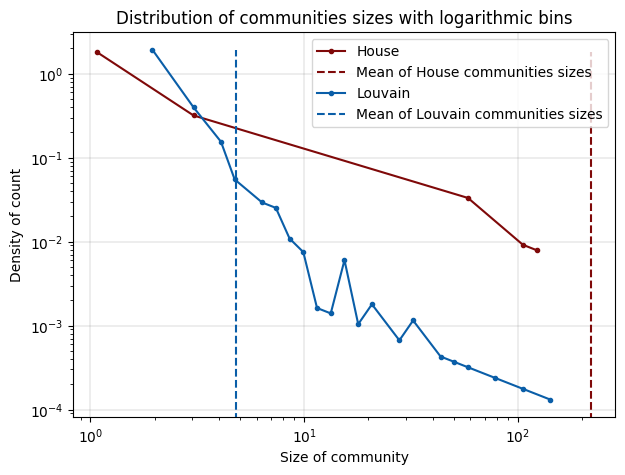

In [74]:
bins = np.logspace(0, np.log10(max(size_comm)),50)
hist, edges = np.histogram(list(size_comm), bins = bins, density = True)
x = (edges[1:] + edges[:-1])/2
xx, yy = zip(*[(i, j) for (i,j) in zip(x, hist) if j>0])

fig, ax = plt.subplots(dpi=100,figsize=(7,5))
ax.plot(xx, yy, marker='.', label='House', color=('#7f0909'))
ax.vlines(np.mean(size_comm),  0, max(yy), ls="--", colors=('#7f0909'), label='Mean of House communities sizes')

hist, edges = np.histogram(list(size_comm_lou), bins = bins, density = True)
x = (edges[1:] + edges[:-1])/2
xx, yy = zip(*[(i, j) for (i,j) in zip(x, hist) if j>0])
ax.plot(xx, yy, marker='.', label='Louvain', color=('#0a5ea8'))

ax.set_xlabel('Size of community')
ax.set_ylabel('Density of count')
ax.set_title("Distribution of communities sizes with logarithmic bins")
ax.vlines(np.mean(size_comm_lou),  0, max(yy), ls="--", colors=('#0a5ea8'), label='Mean of Louvain communities sizes')
ax.legend(loc='upper right')
ax.grid(color='grey', linestyle='-', linewidth=0.2)
ax.set_yscale("log",base=10)
ax.set_xscale("log",base=10)
#plt.savefig('static/images/houses_communities.png', dpi=300)
plt.show()

To explain why the mean of the house community sizes is very skewed towards right, a table of the house community sizes is arranged below:

In [ ]:
# House community sizes
from tabulate import tabulate
columns = ['House', 'Size']
rows = []
for i in range(len(houses_types)):
    rows.append([houses_types[i], size_comm[i]])

print(tabulate(rows, columns))

House          Size
-----------  ------
Unknown        1399
Hufflepuff       61
Slytherin       118
Ravenclaw        61
Gryffindor      107
Thunderbird       3
Pukwudgie         1
Wampus            1


In [93]:
# Fraction of the unknown community of all
frac_unknown = size_comm[0]/sum(size_comm)
print('Fraction of unknown house community of all: ' + str(frac_unknown))

Fraction of unknown house community of all: 0.7989720159908623


Here it is seen, that the distribution of members in each house community is very unequally distributed. The unknown house is approximately 80% of all characters.

## Making random network <a id='make-random-network'></a>

To compare out Harry Potter graph, we create a random graph. It has the same number of nodes and edges. It will still be directed, but the in- and out-degrees of the nodes will not be upheld. The edges will have the same distribution of weights, but they will be assigned the edges randomly.

In [ ]:
# Initliazing random graph with same number of nodes and edges as Harry Potter network
rand_G = nx.gnm_random_graph(len(G.nodes(data=True)), len(G.edges()), seed=42, directed=True)
print(rand_G)

DiGraph with 1751 nodes and 7852 edges


In [ ]:
#collect lists of weights:
weights = []
for (name1, name2, weight) in G.edges.data():
    weights.append(weight['weight'])
# randomize list:
random.shuffle(weights)

rand_G.edges.data("weight",default=1)

for tupl in rand_G.edges.data():
    tupl[2]['weight'] = weights.pop()

#rand_G.edges.data()

#### Visualizing random graph <a id='visualizing_random_graph'></a>

In [ ]:
# Visualizing random graph
netwulf.interactive.visualize(rand_G)

(None, None)

# 4. Text analysis of communities/houses <a id='semantic-analysis'></a>

## Statistics <a id='semantic-analysis_statistics'></a>

In [95]:
import statistics
shortest = min(filtered_data['Wiki text'], key=len)
longest = max(filtered_data['Wiki text'], key=len)
avg_length = sum(len(text) for text in filtered_data['Wiki text']) / len(filtered_data['Wiki text'])
median_length = statistics.median(len(text) for text in filtered_data['Wiki text'])

print('The shortest wiki text is', len(shortest),'characters (with spaces)')
print('The longest wiki text is', len(longest),'characters (with spaces)')
print('The average length of a wiki text is', (avg_length),'characters (with spaces)')
print('The median is', (median_length),'characters (with spaces)')


The shortest wiki text is 126 characters (with spaces)
The longest wiki text is 285806 characters (with spaces)
The average length of a wiki text is 4486.303479749002 characters (with spaces)
The median is 1004 characters (with spaces)


### Distribution of text lengths <a id='dist_text_length'></a>

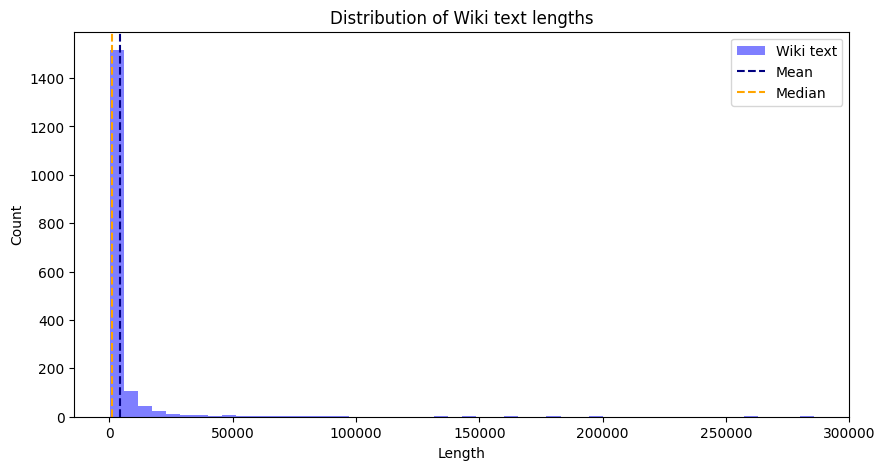

In [96]:
wiki_lengths = [len(text) for text in filtered_data['Wiki text']]

fig, axes = plt.subplots(figsize=(10,5), dpi=100)
axes.hist(wiki_lengths, bins=50, color='blue', alpha=0.5, label='Wiki text')
axes.axvline(sum(wiki_lengths)/len(wiki_lengths), color='navy', linestyle='--', label='Mean')
axes.axvline(sorted(wiki_lengths)[len(wiki_lengths)//2], color='orange', linestyle='--', label='Median')
axes.set_title('Distribution of Wiki text lengths')
axes.set_xlabel('Length')
axes.set_ylabel('Count')
axes.legend()
# plt.savefig('Distribution_wiki_text.png', dpi=300)
plt.show()

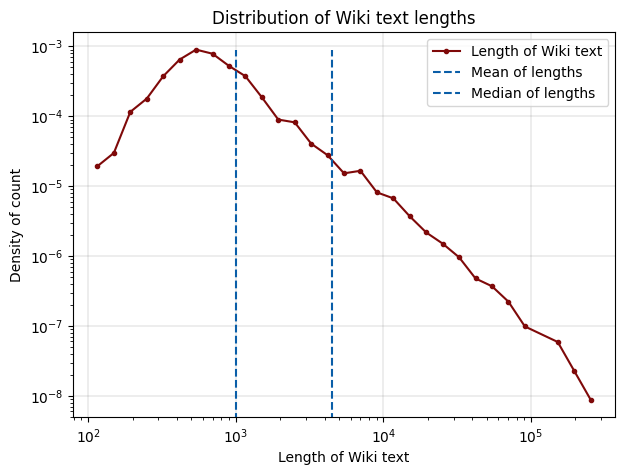

In [99]:
wiki_lengths = [len(text) for text in filtered_data['Wiki text']]

bins = np.logspace(0, np.log10(max(wiki_lengths)),50)
hist, edges = np.histogram(list(wiki_lengths), bins = bins, density = True)
x = (edges[1:] + edges[:-1])/2
xx, yy = zip(*[(i, j) for (i,j) in zip(x, hist) if j>0])
fig, ax = plt.subplots(dpi=100,figsize=(7,5))
ax.plot(xx, yy, marker='.', label='Length of Wiki text', color=('#7f0909'))
ax.set_xlabel('Length of Wiki text')
ax.set_ylabel('Density of count')
ax.set_title("Distribution of Wiki text lengths")
ax.vlines(np.mean(wiki_lengths),  0, max(yy), ls="--", colors=('#0a5ea8'), label='Mean of lengths')
ax.vlines(np.median(wiki_lengths),  0, max(yy), ls="--", colors=('#0a5ea8'), label='Median of lengths')
ax.legend(loc='upper right')
ax.grid(color='grey', linestyle='-', linewidth=0.2)
ax.set_yscale("log",base=10)
ax.set_xscale("log",base=10)
#plt.savefig('Distribution_wiki_text.png', dpi=300)
plt.show()

## Tokenize <a id='tokenize'></a>

In [101]:
# Function to tokenize text
def tokenize_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words and token != 'none' and token != 'nan']
    return tokens

# Add column 'tokens' to df
filtered_data['tokens'] = filtered_data['Wiki text'].apply(tokenize_text) 

### Distribution of tokenized text lengths <a id='dist__tokenized_text_length'></a>

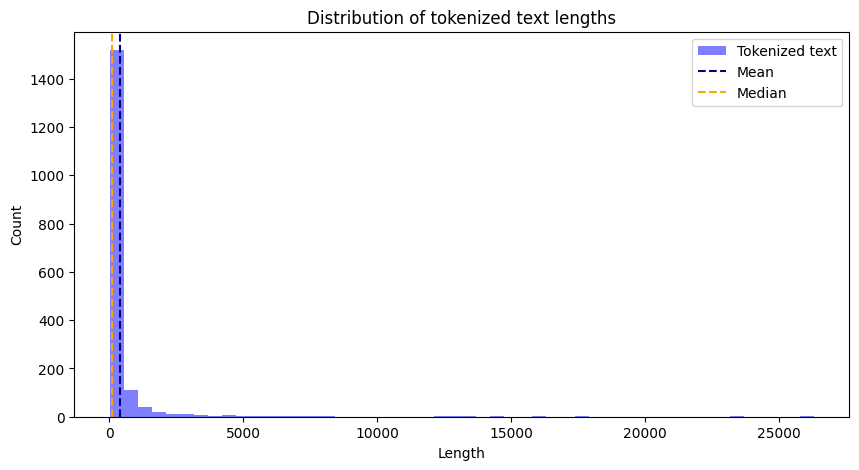

In [102]:
token_lengths = [len(tokens) for tokens in filtered_data['tokens']]

# Plot the distribution of the tokenized text lengths
fig, axes = plt.subplots(figsize=(10,5), dpi=100)
axes.hist(token_lengths, bins=50, color='blue', alpha=0.5, label='Tokenized text')
axes.axvline(sum(token_lengths)/len(token_lengths), color='navy', linestyle='--', label='Mean')
axes.axvline(sorted(token_lengths)[len(token_lengths)//2], color='orange', linestyle='--', label='Median')
axes.set_title('Distribution of tokenized text lengths')
axes.set_xlabel('Length')
axes.set_ylabel('Count')
axes.legend()
# plt.savefig('Distribution_wiki_text_tokenized.png', dpi=300)

plt.show()

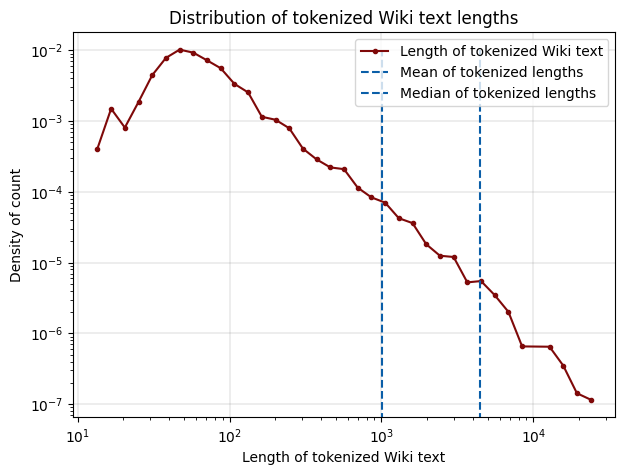

In [103]:
token_lengths = [len(tokens) for tokens in filtered_data['tokens']]
bins = np.logspace(0, np.log10(max(token_lengths)),50)
hist, edges = np.histogram(list(token_lengths), bins = bins, density = True)
x = (edges[1:] + edges[:-1])/2
xx, yy = zip(*[(i, j) for (i,j) in zip(x, hist) if j>0])
fig, ax = plt.subplots(dpi=100,figsize=(7,5))
ax.plot(xx, yy, marker='.', label='Length of tokenized Wiki text', color=('#7f0909'))
ax.set_xlabel('Length of tokenized Wiki text')
ax.set_ylabel('Density of count')
ax.set_title("Distribution of tokenized Wiki text lengths")
ax.vlines(np.mean(wiki_lengths),  0, max(yy), ls="--", colors=('#0a5ea8'), label='Mean of tokenized lengths')
ax.vlines(np.median(wiki_lengths),  0, max(yy), ls="--", colors=('#0a5ea8'), label='Median of tokenized lengths')
ax.legend(loc='upper right')
ax.grid(color='grey', linestyle='-', linewidth=0.2)
ax.set_yscale("log",base=10)
ax.set_xscale("log",base=10)
#plt.savefig('Distribution_wiki_text_tokenized.png', dpi=300)
plt.show()

### Comparing text and tokenized text <a id='text_compare'></a>

In [12]:
def compute_difference(row):
    return len(row["Wiki text"]) - len(row["tokens"])

filtered_data["length_difference"] = filtered_data.apply(compute_difference, axis=1)

average_wiki_length = filtered_data["Wiki text"].str.len().mean()
print(f"Average length of 'Wiki text': {average_wiki_length:.2f}")
average_tokens_length = filtered_data["tokens"].str.len().mean()
print(f"Average length of 'tokens': {average_tokens_length:.2f}")
average_difference = filtered_data["length_difference"].mean()
print(f"Average difference: {average_difference:.2f}")

Average length of 'Wiki text': 4486.30
Average length of 'tokens': 405.92
Average difference: 4080.38


We see that tokenizing the text drastically reduced the amount of words in each charecters wikipedia text. This makes sense, since Wikipedia articles often are written in a very formal style and aim to provide comprehensive and neutral information on a particular topic. As a result, they often contain a lot of common and generic words known as stopwords. By tokenizing the text we also remove things such as punctuation, numbers, and special characters, which also plays a part in the reduction.

## House wordclouds  <a id='house-wordclouds'></a>

In [104]:
house_documents = {}

for house in filtered_data['House'].unique():
    if house is None or house == "None":
        continue
    house_df = filtered_data[filtered_data['House'] == house]
    house_document = ' '.join(house_df['tokens'].explode().tolist())
    house_documents[house] = house_document

# Print the names of the house documents
print("Names of house documents:")
for house in house_documents:
    print(house)
    
# Count the number of house documents
num_houses = len(house_documents)
print("Number of house documents:", num_houses)

Names of house documents:
Unknown
Hufflepuff
Slytherin
Ravenclaw
Gryffindor
Thunderbird
Pukwudgie
Wampus
Number of house documents: 8


### TD-IDF scores <a id='house_td_idf'></a>

Top 10 words and scores for Gryffindor :
harry 0.5861462680076663
ron 0.2347650556979932
hogwarts 0.22301403005913825
hermione 0.22199220174271608
dumbledore 0.1720503427775826
weasley 0.1438223355364202
year 0.14011820788938983
school 0.13564770900504286
potter 0.13168812427890694
voldemort 0.11661615661167997
--------------------------


TypeError: 'dict' object is not callable

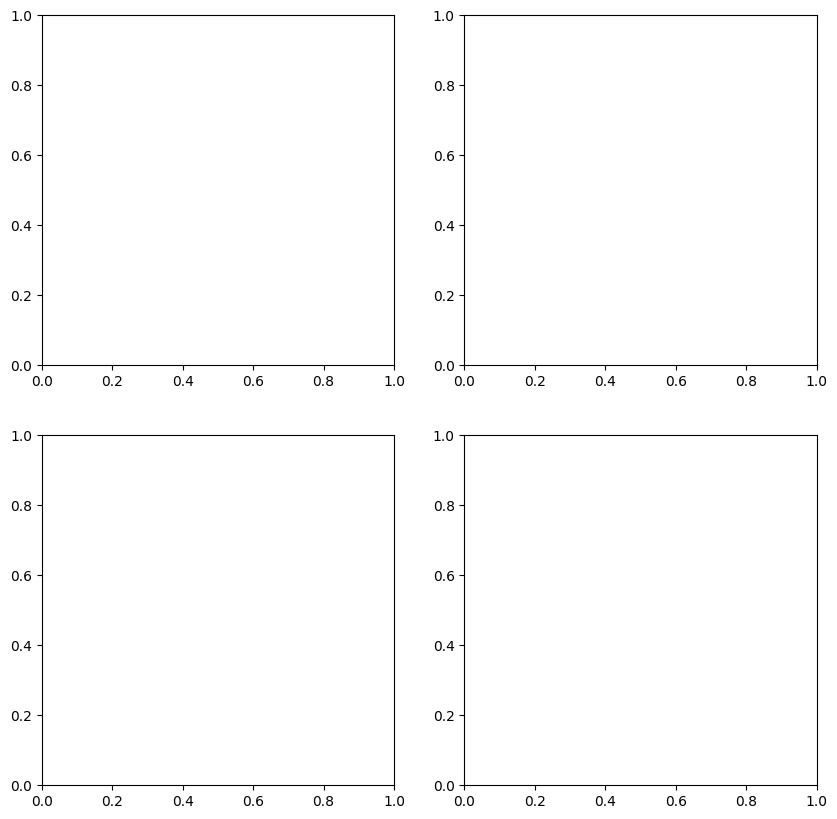

In [108]:
house_colors = {
    "Gryffindor": "#7F0909",
    "Hufflepuff": "#FFC500",
    "Ravenclaw": "#0A5EA8",
    "Slytherin": "#1A472A"
}

def generate_wordcloud_tf_idf(tfidf_scores, ax):
    for house, tfidf in tfidf_scores.items():
        data = dict(tfidf)
        color = house_colors.get(house, 'white')
        wordcloud = WordCloud(width=800, height=800, background_color=color,
                              min_font_size=10, colormap='viridis')
        wordcloud.generate_from_frequencies(frequencies=data)
        ax.imshow(wordcloud)
        ax.axis("off")
        ax.set_title(house, fontsize=16)

vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', use_idf=True)
selected_houses = ['Gryffindor', 'Slytherin', 'Hufflepuff', 'Ravenclaw']

fig, axs = plt.subplots(2, 2, figsize=(10,10))

for i, house in enumerate(selected_houses):
    document = house_documents.get(house)
    if document is None:
        continue
    tfidf = vectorizer.fit_transform([document])
    words = vectorizer.get_feature_names()
    scores = tfidf.toarray()[0]
    # Top 100 words
    top100_scores = sorted(zip(words, scores), key=lambda x: x[1], reverse=True)[:100]
    top10_scores = sorted(zip(words, scores), key=lambda x: x[1], reverse=True)[:10]
    
    print("Top 10 words and scores for", house, ":")
    for word, score in top10_scores:
        print(word, score)
    print("--------------------------")
    
    generate_wordcloud_tf_idf({house: top100_scores}, axs[i//2, i%2])

plt.tight_layout(pad=0)
# plt.savefig('wordclouds.png', dpi=300)
plt.show()



## Personal wordclouds <a id='personal-wordclouds'></a>

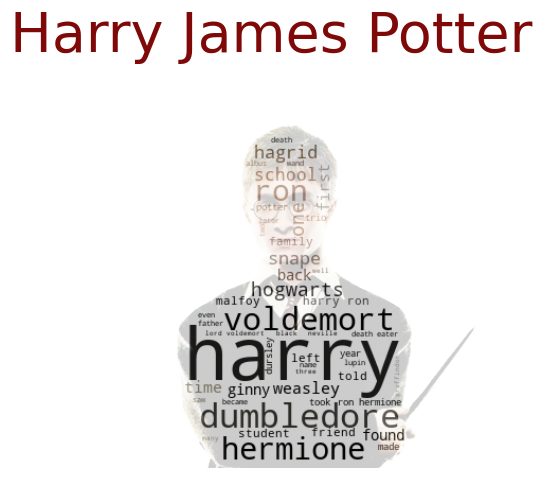

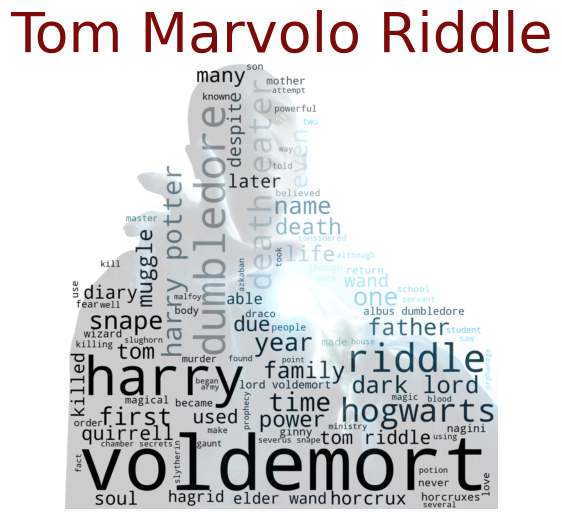

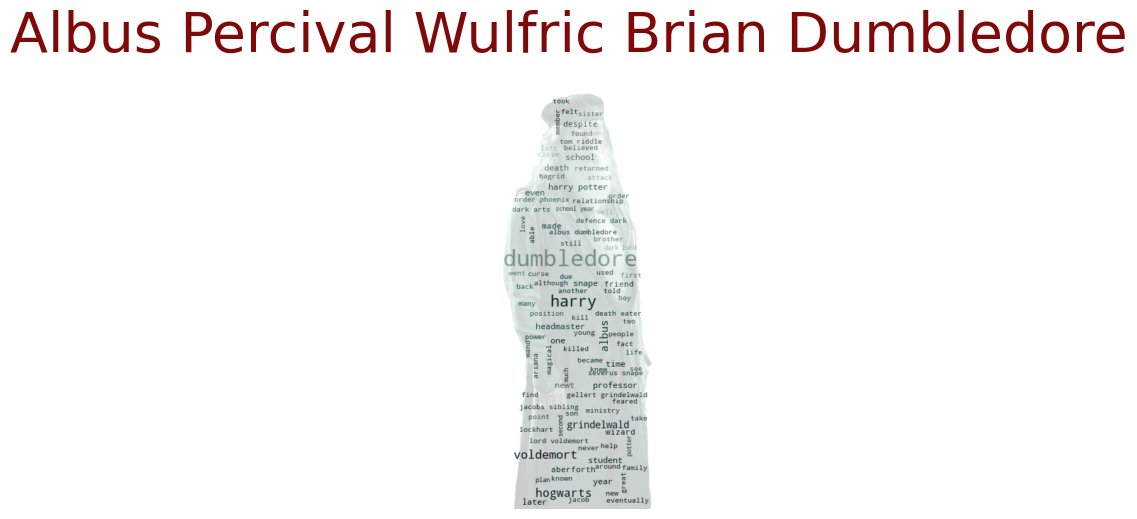

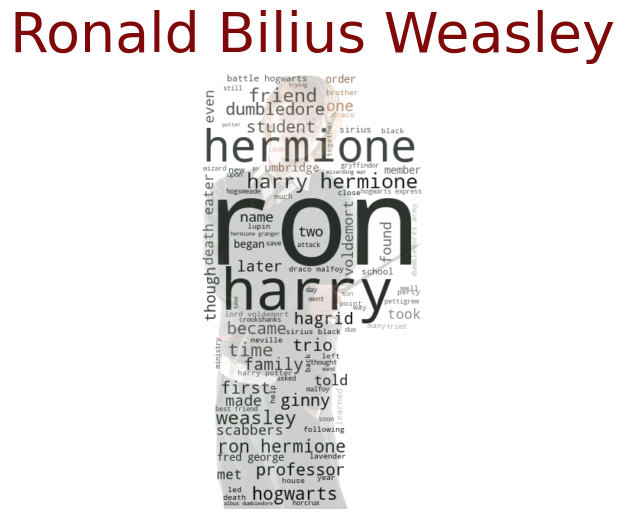

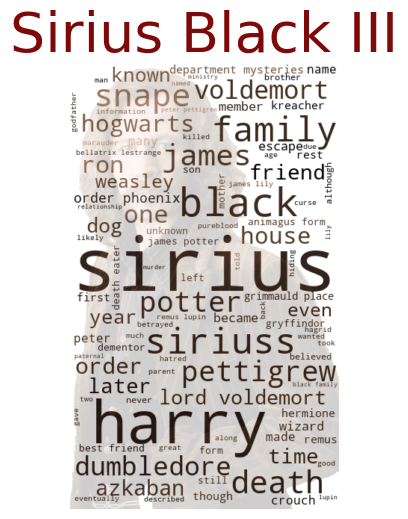

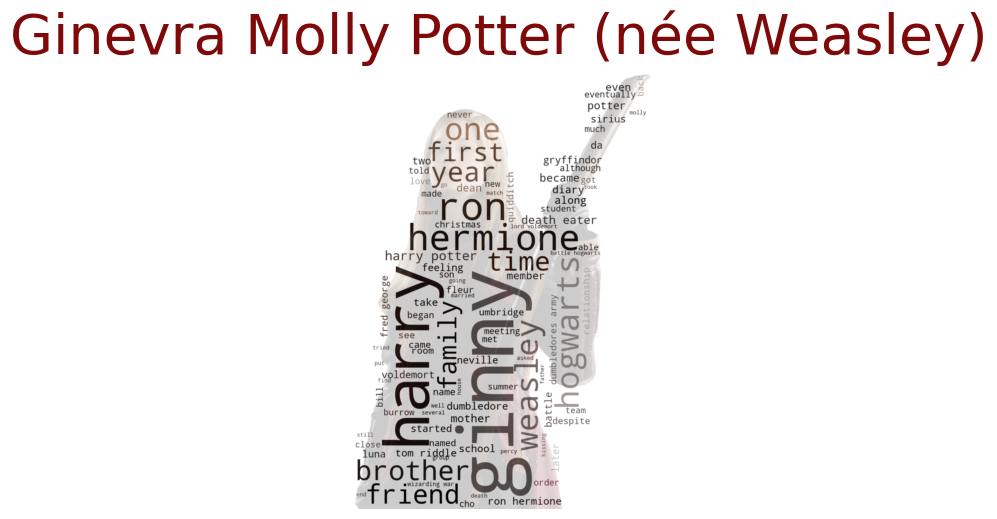

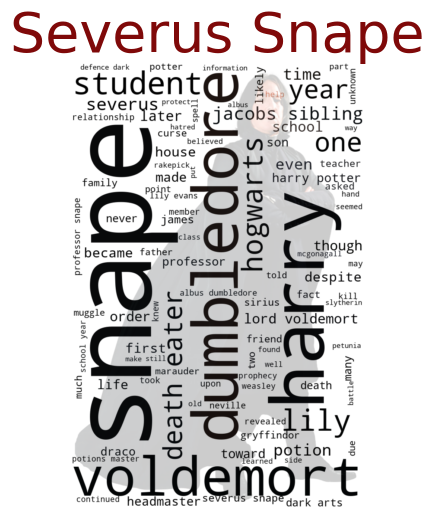

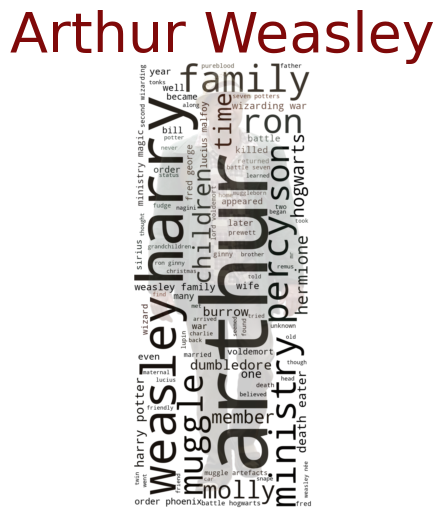

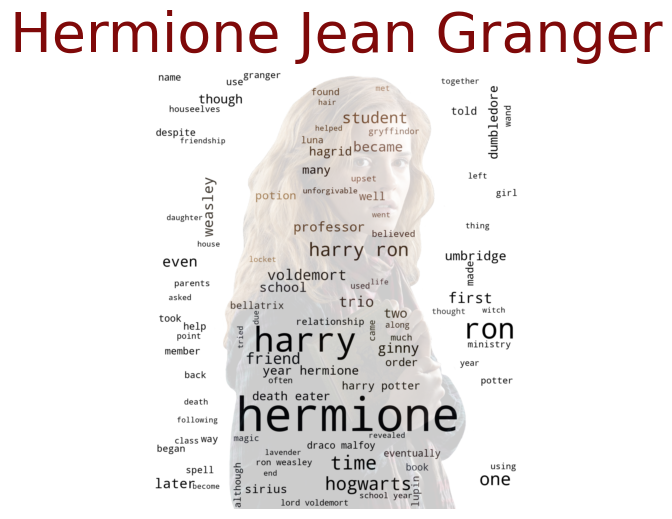

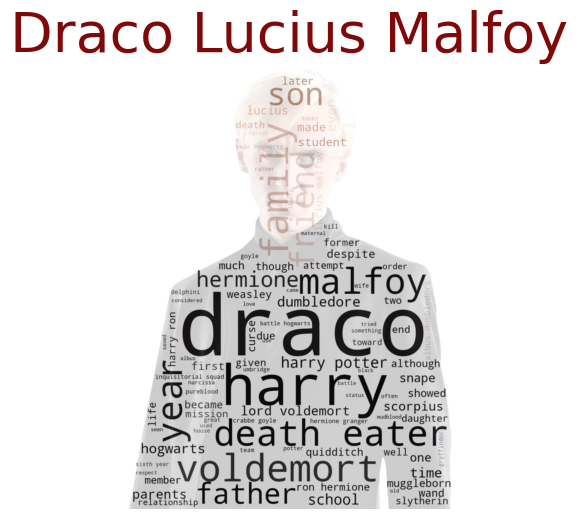

In [110]:
## Special wordclouds
top_10_characters = ['Harry James Potter', 'Tom Marvolo Riddle', 'Albus Percival Wulfric Brian Dumbledore', 'Ronald Bilius Weasley', 'Hermione Jean Granger', 'Sirius Black III', 'Ginevra Molly Potter (née Weasley)', 'Severus Snape', 'Arthur Weasley', 'Draco Lucius Malfoy']
df = filtered_data[filtered_data['Name'].isin(top_10_characters)]

# Load the image paths 
image_paths = {
    "Harry James Potter": "Charecter_png/harry_potter.png",
    "Tom Marvolo Riddle": "Charecter_png/tom_riddle.png",
    "Albus Percival Wulfric Brian Dumbledore": "Charecter_png/Albus.png",
    "Ronald Bilius Weasley": "Charecter_png/ron_weasley.png",
    "Sirius Black III": "Charecter_png/siruis_black.png",
    "Ginevra Molly Potter (née Weasley)": "Charecter_png/ginny.png",
    "Severus Snape": "Charecter_png/Snape.png",
    "Arthur Weasley": "Charecter_png/Arthur.png",
    "Hermione Jean Granger": "Charecter_png/hermione_granger.png",
    "Draco Lucius Malfoy": "Charecter_png/Draco_Malfoy.png",
}

for character in image_paths:
    # Load image 
    img = Image.open(image_paths[character])
    documents = df[df['Name'] == character]['tokens']

    text = ' '.join(documents.apply(lambda x: ' '.join(x)))
    mask = np.array(img)
    stopwords = set(STOPWORDS)
    wc = WordCloud(background_color="white", stopwords=stopwords, mask=mask, width=3000, height=3000, 
                   max_words=100, max_font_size=300, min_font_size=5)
    wc.generate(text)
    image_colors = ImageColorGenerator(mask)
    
    # Figure
    fig, ax = plt.subplots(figsize=(5,5))
    ax.imshow(wc.recolor(color_func=image_colors), interpolation='bilinear')
    ax.imshow(mask, cmap=plt.cm.gray, alpha=0.2, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(character, fontsize=40, color='#7F0909')

    plt.tight_layout(pad=0)
    # plt.savefig(f"static/images/{character}.png", format='png', dpi=300)
    plt.show()
